In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)

In [2]:
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    return dataset[:int(data_size*percentage/100)]

def make_dataset(dataset, n_bus):
    x_raw_1, y_raw_1 = [], []
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        for n in range(n_bus):
            x_raw_1.extend(dataset[i, 4*n+1:4*n+3])
            y_raw_1.extend(dataset[i, 4*n+3:4*n+5])
        x_raw.append(x_raw_1)
        y_raw.append(y_raw_1)
        x_raw_1, y_raw_1 = [], []
        
    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw

def normalize_dataset(x, y):
    x_mean = torch.mean(x,0)
    y_mean = torch.mean(y,0)
    x_std = torch.std(x,0)
    y_std = torch.std(y,0)
    x_norm = (x-x_mean)/x_std
    y_norm = (y-y_mean)/y_std
    x_norm = torch.where(torch.isnan(x_norm), torch.zeros_like(x_norm), x_norm)
    y_norm = torch.where(torch.isnan(y_norm), torch.zeros_like(y_norm), y_norm)
    x_norm = torch.where(torch.isinf(x_norm), torch.zeros_like(x_norm), x_norm)
    y_norm = torch.where(torch.isinf(y_norm), torch.zeros_like(y_norm), y_norm)
    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

def denormalize_output(y_norm, y_mean, y_std):
    y = y_norm*y_std+y_mean
    return y

def NRMSE(yhat,y):
    return torch.sqrt(torch.mean(((yhat-y)/torch.std(yhat,0))**2))

def MSE(yhat,y):
    return torch.mean((yhat-y)**2)

In [3]:
dataset1 = pd.read_excel('dataset\Grid_14 bus_1.xlsx').values
dataset2 = pd.read_excel('dataset\Grid_14 bus_2.xlsx').values

In [4]:
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 14

#actual data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

#normalized data
x_norm_train, y_norm_train, _, _, _, _ = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

In [5]:
class My_NN(torch.nn.Module):
    def __init__(self, input_size=None, hidden_size1=None, hidden_size2=None, output_size=None):
        super(My_NN, self).__init__()
        self.input_size = input_size if input_size is not None else 18 
        self.hidden_size1 = hidden_size1 if hidden_size1 is not None else 38
        self.hidden_size2 = hidden_size2 if hidden_size2 is not None else 38
        self.output_size = output_size if output_size is not None else 18
        
        self.lin1 = Linear(self.input_size, self.hidden_size1)
        self.lin2 = Linear(self.hidden_size1, self.hidden_size2)
        self.lin3 = Linear(self.hidden_size2, self.output_size)

    def forward(self, x):
        
        x = self.lin1(x)
        x = torch.tanh(x)

        x = self.lin2(x)
        x = torch.tanh(x)

        x = self.lin3(x)

        return x
    
    def save_weights(self, model, name):
        torch.save(model, name)

In [6]:
%%time

input_size = n_bus*2
hidden_size1 = 30
hidden_size2 = 30
output_size = n_bus*2
lr = 0.001

model = My_NN(input_size, hidden_size1, hidden_size2, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss_list, val_loss_list = [], []

count=0
patience=10000
lossMin = 1e10

for epoch in range(10001):

    model.train()
    optimizer.zero_grad()
    y_train_prediction = model(x_norm_train)
    train_loss = MSE(denormalize_output(y_train_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_train, y_val_mean, y_val_std))
    train_loss.backward()
    optimizer.step()
    train_loss_list.append(train_loss.detach())

    model.eval()
    y_val_prediction = model(x_norm_val)
    val_loss = MSE(denormalize_output(y_val_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_val, y_val_mean, y_val_std))
    val_loss_list.append(val_loss.detach())

    #early stopping
    if (val_loss < lossMin):
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss
        model.save_weights(model, "[PyG] [14 bus] Best_NN_model.pt")
    else:
        count+=1
        if(count>patience):
            print("early stop at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
            print("best val at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(best_epoch, best_train_loss, best_val_loss))
            break
    
    #if (train_loss <= 0):
    #    print("min train loss at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
    #    break

    if (epoch % 10) == 0:
        print('epoch: {:d}    train loss: {:.7f}    val loss: {:.7f}'.format(epoch, train_loss, val_loss))

epoch: 0    train loss: 0.3572779    val loss: 0.3549372
epoch: 10    train loss: 0.3271315    val loss: 0.3258092
epoch: 20    train loss: 0.2890157    val loss: 0.2879375
epoch: 30    train loss: 0.2325724    val loss: 0.2308816
epoch: 40    train loss: 0.1559985    val loss: 0.1535463
epoch: 50    train loss: 0.0816438    val loss: 0.0793228
epoch: 60    train loss: 0.0394573    val loss: 0.0375504
epoch: 70    train loss: 0.0226896    val loss: 0.0213710
epoch: 80    train loss: 0.0166587    val loss: 0.0159275
epoch: 90    train loss: 0.0147257    val loss: 0.0142873
epoch: 100    train loss: 0.0133413    val loss: 0.0130554
epoch: 110    train loss: 0.0122153    val loss: 0.0119590
epoch: 120    train loss: 0.0111635    val loss: 0.0109526
epoch: 130    train loss: 0.0102636    val loss: 0.0100893
epoch: 140    train loss: 0.0094546    val loss: 0.0093021
epoch: 150    train loss: 0.0087223    val loss: 0.0085963
epoch: 160    train loss: 0.0080692    val loss: 0.0079720
epoch: 1

epoch: 1390    train loss: 0.0006086    val loss: 0.0014171
epoch: 1400    train loss: 0.0006022    val loss: 0.0014076
epoch: 1410    train loss: 0.0005959    val loss: 0.0013985
epoch: 1420    train loss: 0.0005898    val loss: 0.0013896
epoch: 1430    train loss: 0.0005839    val loss: 0.0013807
epoch: 1440    train loss: 0.0005780    val loss: 0.0013719
epoch: 1450    train loss: 0.0005722    val loss: 0.0013632
epoch: 1460    train loss: 0.0005665    val loss: 0.0013545
epoch: 1470    train loss: 0.0005609    val loss: 0.0013460
epoch: 1480    train loss: 0.0005554    val loss: 0.0013376
epoch: 1490    train loss: 0.0005500    val loss: 0.0013292
epoch: 1500    train loss: 0.0005446    val loss: 0.0013209
epoch: 1510    train loss: 0.0005394    val loss: 0.0013128
epoch: 1520    train loss: 0.0005353    val loss: 0.0013071
epoch: 1530    train loss: 0.0005292    val loss: 0.0012976
epoch: 1540    train loss: 0.0005242    val loss: 0.0012893
epoch: 1550    train loss: 0.0005192    

epoch: 2760    train loss: 0.0002129    val loss: 0.0007114
epoch: 2770    train loss: 0.0002111    val loss: 0.0007093
epoch: 2780    train loss: 0.0002097    val loss: 0.0007058
epoch: 2790    train loss: 0.0002084    val loss: 0.0007035
epoch: 2800    train loss: 0.0002076    val loss: 0.0007026
epoch: 2810    train loss: 0.0002077    val loss: 0.0007002
epoch: 2820    train loss: 0.0002052    val loss: 0.0006961
epoch: 2830    train loss: 0.0002041    val loss: 0.0006942
epoch: 2840    train loss: 0.0002024    val loss: 0.0006913
epoch: 2850    train loss: 0.0002011    val loss: 0.0006885
epoch: 2860    train loss: 0.0002008    val loss: 0.0006869
epoch: 2870    train loss: 0.0002018    val loss: 0.0006856
epoch: 2880    train loss: 0.0001989    val loss: 0.0006827
epoch: 2890    train loss: 0.0001969    val loss: 0.0006777
epoch: 2900    train loss: 0.0001953    val loss: 0.0006758
epoch: 2910    train loss: 0.0001941    val loss: 0.0006735
epoch: 2920    train loss: 0.0001930    

epoch: 4130    train loss: 0.0001022    val loss: 0.0004741
epoch: 4140    train loss: 0.0001022    val loss: 0.0004735
epoch: 4150    train loss: 0.0001180    val loss: 0.0004840
epoch: 4160    train loss: 0.0001084    val loss: 0.0004823
epoch: 4170    train loss: 0.0001017    val loss: 0.0004686
epoch: 4180    train loss: 0.0000999    val loss: 0.0004691
epoch: 4190    train loss: 0.0000996    val loss: 0.0004693
epoch: 4200    train loss: 0.0000989    val loss: 0.0004674
epoch: 4210    train loss: 0.0000985    val loss: 0.0004678
epoch: 4220    train loss: 0.0001086    val loss: 0.0004803
epoch: 4230    train loss: 0.0001008    val loss: 0.0004672
epoch: 4240    train loss: 0.0000975    val loss: 0.0004638
epoch: 4250    train loss: 0.0000970    val loss: 0.0004649
epoch: 4260    train loss: 0.0000967    val loss: 0.0004687
epoch: 4270    train loss: 0.0001011    val loss: 0.0004756
epoch: 4280    train loss: 0.0001006    val loss: 0.0004575
epoch: 4290    train loss: 0.0000971    

epoch: 5500    train loss: 0.0000540    val loss: 0.0003606
epoch: 5510    train loss: 0.0000530    val loss: 0.0003608
epoch: 5520    train loss: 0.0000527    val loss: 0.0003584
epoch: 5530    train loss: 0.0000523    val loss: 0.0003571
epoch: 5540    train loss: 0.0000536    val loss: 0.0003564
epoch: 5550    train loss: 0.0000685    val loss: 0.0003610
epoch: 5560    train loss: 0.0000531    val loss: 0.0003575
epoch: 5570    train loss: 0.0000534    val loss: 0.0003579
epoch: 5580    train loss: 0.0000513    val loss: 0.0003517
epoch: 5590    train loss: 0.0000508    val loss: 0.0003556
epoch: 5600    train loss: 0.0000505    val loss: 0.0003535
epoch: 5610    train loss: 0.0000502    val loss: 0.0003535
epoch: 5620    train loss: 0.0000503    val loss: 0.0003532
epoch: 5630    train loss: 0.0000678    val loss: 0.0003787
epoch: 5640    train loss: 0.0000605    val loss: 0.0003642
epoch: 5650    train loss: 0.0000527    val loss: 0.0003450
epoch: 5660    train loss: 0.0000501    

epoch: 6870    train loss: 0.0000266    val loss: 0.0002971
epoch: 6880    train loss: 0.0000272    val loss: 0.0003017
epoch: 6890    train loss: 0.0000319    val loss: 0.0003265
epoch: 6900    train loss: 0.0000281    val loss: 0.0002885
epoch: 6910    train loss: 0.0000347    val loss: 0.0002715
epoch: 6920    train loss: 0.0000272    val loss: 0.0003040
epoch: 6930    train loss: 0.0000263    val loss: 0.0002691
epoch: 6940    train loss: 0.0000253    val loss: 0.0002794
epoch: 6950    train loss: 0.0000251    val loss: 0.0002827
epoch: 6960    train loss: 0.0000248    val loss: 0.0002775
epoch: 6970    train loss: 0.0000259    val loss: 0.0002704
epoch: 6980    train loss: 0.0000541    val loss: 0.0002848
epoch: 6990    train loss: 0.0000370    val loss: 0.0003207
epoch: 7000    train loss: 0.0000272    val loss: 0.0002632
epoch: 7010    train loss: 0.0000249    val loss: 0.0002778
epoch: 7020    train loss: 0.0000247    val loss: 0.0002825
epoch: 7030    train loss: 0.0000240    

epoch: 8250    train loss: 0.0000157    val loss: 0.0002633
epoch: 8260    train loss: 0.0000182    val loss: 0.0002833
epoch: 8270    train loss: 0.0000240    val loss: 0.0002938
epoch: 8280    train loss: 0.0000192    val loss: 0.0002313
epoch: 8290    train loss: 0.0000162    val loss: 0.0002537
epoch: 8300    train loss: 0.0000162    val loss: 0.0002683
epoch: 8310    train loss: 0.0000249    val loss: 0.0002869
epoch: 8320    train loss: 0.0000161    val loss: 0.0002356
epoch: 8330    train loss: 0.0000151    val loss: 0.0002410
epoch: 8340    train loss: 0.0000146    val loss: 0.0002549
epoch: 8350    train loss: 0.0000145    val loss: 0.0002504
epoch: 8360    train loss: 0.0000145    val loss: 0.0002549
epoch: 8370    train loss: 0.0000234    val loss: 0.0003009
epoch: 8380    train loss: 0.0000189    val loss: 0.0002544
epoch: 8390    train loss: 0.0000148    val loss: 0.0002588
epoch: 8400    train loss: 0.0000148    val loss: 0.0002354
epoch: 8410    train loss: 0.0000144    

epoch: 9630    train loss: 0.0000101    val loss: 0.0002217
epoch: 9640    train loss: 0.0000104    val loss: 0.0002431
epoch: 9650    train loss: 0.0000101    val loss: 0.0002268
epoch: 9660    train loss: 0.0000100    val loss: 0.0002332
epoch: 9670    train loss: 0.0000111    val loss: 0.0002431
epoch: 9680    train loss: 0.0000304    val loss: 0.0002877
epoch: 9690    train loss: 0.0000135    val loss: 0.0002208
epoch: 9700    train loss: 0.0000106    val loss: 0.0002120
epoch: 9710    train loss: 0.0000108    val loss: 0.0002364
epoch: 9720    train loss: 0.0000123    val loss: 0.0002078
epoch: 9730    train loss: 0.0000189    val loss: 0.0002052
epoch: 9740    train loss: 0.0000120    val loss: 0.0002434
epoch: 9750    train loss: 0.0000101    val loss: 0.0002268
epoch: 9760    train loss: 0.0000100    val loss: 0.0002341
epoch: 9770    train loss: 0.0000115    val loss: 0.0002455
epoch: 9780    train loss: 0.0000189    val loss: 0.0002877
epoch: 9790    train loss: 0.0000117    

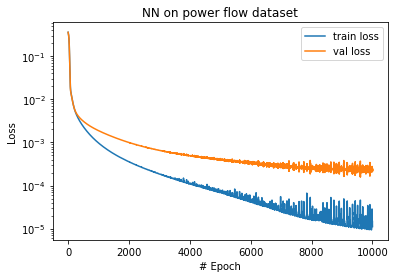

last epoch: 10000, train loss: 0.0000112, val loss: 0.0002226
best epoch: 9602, train loss: 0.0000455, val loss: 0.0001579


In [7]:
plt.title('NN on power flow dataset')
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.yscale('log')
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

print('last epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(epoch, train_loss, val_loss))
print('best epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(best_epoch, best_train_loss, best_val_loss))

In [8]:
for name, param in model.named_parameters():
  print(name)
  print(param.size())

param = sum(p.numel() for p in model.parameters() if p.requires_grad)
param

lin1.weight
torch.Size([30, 28])
lin1.bias
torch.Size([30])
lin2.weight
torch.Size([30, 30])
lin2.bias
torch.Size([30])
lin3.weight
torch.Size([28, 30])
lin3.bias
torch.Size([28])


2668

In [9]:
model.eval()

y_train_prediction = model(x_norm_train)
train_loss = MSE(denormalize_output(y_train_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_train, y_val_mean, y_val_std))
print("Train output ground-truth: \n" + str(y_raw_train.detach().numpy()[0]))
print("Train output prediction: \n" + str(denormalize_output(y_train_prediction, y_val_mean, y_val_std).detach().numpy()[0]))
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("===========================================================================")

y_val_prediction = model(x_norm_val)
val_loss = MSE(denormalize_output(y_val_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_val, y_val_mean, y_val_std))
print("Train output ground-truth: \n" + str(y_raw_val.detach().numpy()[0]))
print("Train output prediction: \n" + str(denormalize_output(y_val_prediction, y_val_mean, y_val_std).detach().numpy()[0]))
print('Train loss (MSE): {:.7f}'.format(val_loss))

Train output ground-truth: 
[  10.324 -154.216    9.882 -156.117    9.753 -156.712    9.724 -156.839
    9.659 -157.161    9.607 -157.399    9.617 -157.37     9.627 -157.311
    9.581 -157.512    9.56  -157.633    9.773 -156.613    9.682 -157.039
    9.658 -157.152    9.664 -157.123]
Train output prediction: 
[  10.32337 -154.21791    9.88046 -156.12112    9.75189 -156.71469
    9.72361 -156.84132    9.65743 -157.16484    9.60688 -157.39487
    9.6149  -157.37616    9.62569 -157.31027    9.58075 -157.51251
    9.56007 -157.62479    9.77127 -156.61847    9.68154 -157.04373
    9.65747 -157.15675    9.66304 -157.12936]
Train loss (MSE): 0.0000113
Train output ground-truth: 
[  10.302 -154.788    9.844 -156.745    9.686 -157.465    9.685 -157.484
    9.574 -157.989    9.568 -158.053    9.543 -158.141    9.532 -158.187
    9.518 -158.294    9.535 -158.209    9.727 -157.275    9.629 -157.731
    9.599 -157.869    9.594 -157.896]
Train output prediction: 
[  10.30176 -154.786      9.84274 -1

In [10]:
best_model = torch.load("[PyG] [14 bus] Best_NN_model.pt")
best_model.eval()

y_train_prediction = best_model(x_norm_train)
train_loss = MSE(denormalize_output(y_train_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_train, y_val_mean, y_val_std))
print("Train output ground-truth: \n" + str(y_raw_train.detach().numpy()[0]))
print("Train output prediction: \n" + str(denormalize_output(y_train_prediction, y_val_mean, y_val_std).detach().numpy()[0]))
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("===========================================================================")

y_val_prediction = best_model(x_norm_val)
val_loss = MSE(denormalize_output(y_val_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_val, y_val_mean, y_val_std))
print("Train output ground-truth: \n" + str(y_raw_val.detach().numpy()[0]))
print("Train output prediction: \n" + str(denormalize_output(y_val_prediction, y_val_mean, y_val_std).detach().numpy()[0]))
print('Train loss (MSE): {:.7f}'.format(val_loss))

Train output ground-truth: 
[  10.324 -154.216    9.882 -156.117    9.753 -156.712    9.724 -156.839
    9.659 -157.161    9.607 -157.399    9.617 -157.37     9.627 -157.311
    9.581 -157.512    9.56  -157.633    9.773 -156.613    9.682 -157.039
    9.658 -157.152    9.664 -157.123]
Train output prediction: 
[  10.32377 -154.2075     9.88146 -156.10791    9.75312 -156.70035
    9.72478 -156.82715    9.65885 -157.14973    9.60828 -157.37967
    9.61632 -157.36072    9.62708 -157.29482    9.58217 -157.49727
    9.56154 -157.60919    9.77247 -156.60439    9.68292 -157.029
    9.65883 -157.14175    9.66444 -157.11444]
Train loss (MSE): 0.0000398
Train output ground-truth: 
[  10.302 -154.788    9.844 -156.745    9.686 -157.465    9.685 -157.484
    9.574 -157.989    9.568 -158.053    9.543 -158.141    9.532 -158.187
    9.518 -158.294    9.535 -158.209    9.727 -157.275    9.629 -157.731
    9.599 -157.869    9.594 -157.896]
Train output prediction: 
[  10.30203 -154.78003    9.84329 -156

In [11]:
%%time

best_model = torch.load("[PyG] [14 bus] Best_NN_model.pt")
best_model.eval()

test_loss_list = []

for i in range(102):
    
    dataset = pd.read_excel('dataset\Grid_14 bus_%d.xlsx' % (i+1)).values
    test_percentage = 100
    test_dataset = slice_dataset(dataset, test_percentage)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, _, _, _, _ = normalize_dataset(x_raw_test, y_raw_test)
    
    print('dataset {:d}'.format(i+1))
    
    y_test_prediction = best_model(x_norm_test)
    test_loss = MSE(denormalize_output(y_test_prediction, y_val_mean, y_val_std), denormalize_output(y_norm_test, y_val_mean, y_val_std))
    
    if i == 0:
        print('Train loss (MSE): {:.7f}'.format(test_loss.detach().numpy()))
    elif i == 1:
        print('Val loss (MSE): {:.7f}'.format(test_loss.detach().numpy()))
    else:
        print('Test loss (MSE): {:.7f}'.format(test_loss))
        test_loss_list.append(test_loss.detach().numpy())
    
    print("===========================")

column = []
for i in range(100):
    column.append('test loss %d' % (i+1))
    
test_loss_file = pd.DataFrame([test_loss_list], columns=column)
test_loss_file.to_excel("[PyG] [14 bus] [MSE] NN test loss.xlsx")
print("\ntest loss file saved!\n")

dataset 1
Train loss (MSE): 0.0000398
dataset 2
Val loss (MSE): 0.0001579
dataset 3
Test loss (MSE): 0.0000688
dataset 4
Test loss (MSE): 0.0001142
dataset 5
Test loss (MSE): 0.0002316
dataset 6
Test loss (MSE): 0.0000720
dataset 7
Test loss (MSE): 0.0001097
dataset 8
Test loss (MSE): 0.0002451
dataset 9
Test loss (MSE): 0.0001211
dataset 10
Test loss (MSE): 0.0001841
dataset 11
Test loss (MSE): 0.0001146
dataset 12
Test loss (MSE): 0.0003957
dataset 13
Test loss (MSE): 0.0000778
dataset 14
Test loss (MSE): 0.0000807
dataset 15
Test loss (MSE): 0.0001075
dataset 16
Test loss (MSE): 0.0000741
dataset 17
Test loss (MSE): 0.0000708
dataset 18
Test loss (MSE): 0.0001177
dataset 19
Test loss (MSE): 0.0001014
dataset 20
Test loss (MSE): 0.0003082
dataset 21
Test loss (MSE): 0.0002131
dataset 22
Test loss (MSE): 0.0001551
dataset 23
Test loss (MSE): 0.0000882
dataset 24
Test loss (MSE): 0.0000836
dataset 25
Test loss (MSE): 0.0001135
dataset 26
Test loss (MSE): 0.0001030
dataset 27
Test loss 

In [12]:
%%time

best_model = torch.load("[PyG] [14 bus] Best_NN_model.pt")
best_model.eval()

test_loss_list = []

for i in range(102):
    
    dataset = pd.read_excel('dataset\Grid_14 bus_%d.xlsx' % (i+1)).values
    test_percentage = 100
    test_dataset = slice_dataset(dataset, test_percentage)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, _, _, _, _ = normalize_dataset(x_raw_test, y_raw_test)
    
    print('dataset {:d}'.format(i+1))
    
    yhat = denormalize_output(best_model(x_norm_test), y_val_mean, y_val_std)
    y = y_raw_test
    test_loss_NRMSE = NRMSE(yhat, y)
    
    if i == 0:
        print('Train loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
    elif i == 1:
        print('Val loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
    else:
        print('Test loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
        test_loss_list.append(test_loss_NRMSE.detach().numpy())
    
    print("===========================")

column = []
for i in range(100):
    column.append('test loss %d' % (i+1))
    
test_loss_file = pd.DataFrame([test_loss_list], columns=column)
test_loss_file.to_excel("[PyG] [14 bus] [NRMSE] NN test loss.xlsx")
print("\ntest loss file saved!\n")

dataset 1
Train loss (NRMSE): 0.0224649
dataset 2
Val loss (NRMSE): 0.0236703
dataset 3
Test loss (NRMSE): 0.0248321
dataset 4
Test loss (NRMSE): 0.0262397
dataset 5
Test loss (NRMSE): 0.0306412
dataset 6
Test loss (NRMSE): 0.0221979
dataset 7
Test loss (NRMSE): 0.0474466
dataset 8
Test loss (NRMSE): 0.0652829
dataset 9
Test loss (NRMSE): 0.0266288
dataset 10
Test loss (NRMSE): 0.0534130
dataset 11
Test loss (NRMSE): 0.0409014
dataset 12
Test loss (NRMSE): 0.0340073
dataset 13
Test loss (NRMSE): 0.0249103
dataset 14
Test loss (NRMSE): 0.0243192
dataset 15
Test loss (NRMSE): 0.0259423
dataset 16
Test loss (NRMSE): 0.0286170
dataset 17
Test loss (NRMSE): 0.0287907
dataset 18
Test loss (NRMSE): 0.0354325
dataset 19
Test loss (NRMSE): 0.0265823
dataset 20
Test loss (NRMSE): 0.0299844
dataset 21
Test loss (NRMSE): 0.0365966
dataset 22
Test loss (NRMSE): 0.0315232
dataset 23
Test loss (NRMSE): 0.0306503
dataset 24
Test loss (NRMSE): 0.0541991
dataset 25
Test loss (NRMSE): 0.0422271
dataset 2